<h1>Cross Correlation Analysis with Transmission Spectroscopy on WASP-121b</h1>
Welcome to this tutorial on high-resolution cross-correlation spectroscopy of exoplanets. Some parts of this tutorial are adopted from ESO workshop on 08/23/2021.
<br>
This tutorial covers how to cross correlate your high resolution data with forward model templates using POSEIDON. We will reproduce the result from [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract), showing a strong Fe detection on WASP-121b using cross-correlation.


You should run this tutorial before running the transmission high resolution retrieval tutorial notebook, where we will demonstrate how to set up a high-resolution retrieval.
<br>

Although focused on transit transmission spectroscopy in the optical, these concepts also apply to day-side emission spectra and infrared wavelengths. See emission_cross_correlate.ipynb to learn more.



<h2>We'll make use of:</h2>

* Spectral orders extracted and processed by the HARPS-N pipeline (e2ds FITS files).
* Wavelength solutions provided by the pipeline, encoded in the FITS headers.
* The observing dates of the time series, corrected for light-travel delay using the RA and DEC coordinates.
* The line-of-sight velocity of Earth with respect to the barycenter during the time series.
* The orbital parameters, to determine the orbital velocity and orbital phase at each time in the time-series.
* Standard python packages and Astropy.
* Three convenience functions defined below.
* Model spectra templates of ionised iron and the spectral continuum.

<br>

![title](../../_static/notebook_images/high-res-trans.png)

### Loading Data

First, we will load the high resolution data for your planet (WASP-121b in our case).

Your data should include
1. raw flux from the observation, This should be a 3D array: NOrders*NExposures*NPixels.
2. wavelength grid of your observations. This should be a 2D array: NOrders*Npixels.
3. orbital phase of each exposure. This should be a 1D array: NExposures.
4. transit weight of each exposure. The value should ne 1 before and after transit; transit depth in mid-transit. This should be a 1D array: NExposures.

Suppose this is the first time you use POSEIDON on this dataset. We will read the dataset in its raw form, processes it, and save it into POSEIDON compatibale format (.hdf5).

This example dataset can be downloaded from POSEIDON's reference data repoistory Zenodo TODO.

In [17]:
import pickle
from POSEIDON.high_res import (
    remove_outliers,
    blaze_correction,
    fit_uncertainties,
    prepare_high_res_data,
    read_hdf5,
)

data_dir = "/home/rwang/final_experiments/data/WASP-121b/"
names = ["blue", "redl", "redu"]
for i in range(len(names)):
    data_raw = read_hdf5(
        data_dir + names[i] + "/data_raw.hdf5"
    )  # only use blue arm for faster retrieval; reading the raw data
    flux = data_raw["flux"]
    wl_grid = data_raw["wl_grid"]
    phi = data_raw["phi"]
    tranist_weight = data_raw["transit_weight"]

    flux = remove_outliers(wl_grid, flux)
    flux = blaze_correction(flux, filter_size=(500, 100))
    uncertainties = fit_uncertainties(flux, n_components=5)
    prepare_high_res_data(
        data_dir,
        names[i],
        "transmission",
        "sysrem",
        flux,
        wl_grid,
        phi,
        uncertainties,
        tranist_weight,
    )


2078 outliers removed from a total of 9302280 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/blue/data_processed.hdf5
Filtering out systematics using SYSREM with 15 iterations
12998 outliers removed from a total of 11863020 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/redl/data_processed.hdf5
Filtering out systematics using SYSREM with 15 iterations
18099 outliers removed from a total of 8210448 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at /home/rwang/final_experiments/data/WASP-121b/redu/data_processed.hdf5
Filtering out systematics using SYSREM with 15 ite

The Earth's transmission spectrum longward of 1 $\mu$m becomes severely affected by the absorption of molecular species in our own atmosphere, primarily water vapour (H<sub>2</sub>O), but also methane (CH<sub>4</sub>) and carbon dioxide (CO<sub>2</sub>). An example of this can be seen in a model transmission spectrum calculated with the [ESO Sky Model Calculator](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) (R=20,000, zenith, 2.5 mm of precipitable water vapour, average yearly conditions at Cerro Paranal).

![Earth's transsmission spectrum](../../_static/notebook_images/high_res_Earth_trans.gif)
Such dominance of telluric lines (telluric = "of the Earth") requires a different approach than for optical spectra. 

In [19]:
from POSEIDON.high_res import read_high_res_data

data_dir = "/home/rwang/final_experiments/data/WASP-121b/"
names = ["blue", "redl", "redu"]
# names = ["blue"]
data = read_high_res_data(data_dir, names=names)

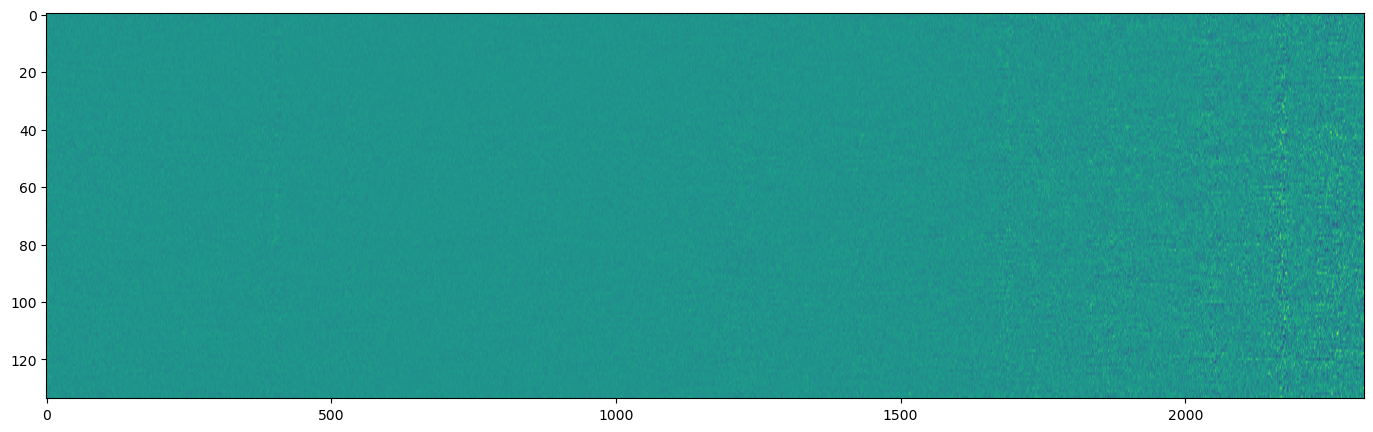

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 5))
plt.imshow(data["blue"]["residuals"][15], aspect="auto")

In [21]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import *
import numpy as np
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.constants import R_J, M_J
import numpy as np

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776  # Stellar effective temperature (K)
Met_s = 0.13  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

R_p = 0.118 * R_s  # Planetary radius (m)
M_p = 1.157 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R, make_atmosphere

# ***** Define model *****#

model_name = "Fe"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
# param_species = ["Fe", "Cr", "Mg", "V"]
param_species = ["Fe"]

high_res_params = ["K_p", "V_sys", "W_conv", "log_a"]

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
)

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 0.87  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2900  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 3100  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -12.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [22]:
param_species = ["Fe"]  # , "Cr", "Mg", "V"]
model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="isotherm",
    high_res_params=high_res_params,
    # cloud_model="MacMad17",
    # cloud_type="deck",
)

# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_species = [-5]
# log_species = [-5, -7, -4, -8]
T = 3000

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])
log_X_params = np.array([log_species])
# cloud_params = np.array([0])

atmosphere = make_atmosphere(
    planet,
    model,
    P,
    P_ref,
    R_p_ref,
    PT_params,
    log_X_params,
)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet,
    star,
    model,
    atmosphere,
    opac,
    wl,
    spectrum_type="transmission",
)

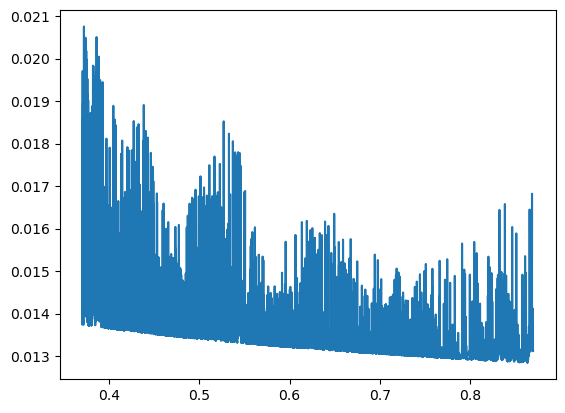

In [23]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

plt.plot(wl, spectrum)

<h2>The cross-correlation function:</h2>

Cross correlation has been used in various flavours since the first application in [Snellen et al. 2010](https://www.nature.com/articles/nature09111). In this example, we use the simple weighted average:
<br>
<br>
<br>
<br>
$$
C(v,t) = \frac{\sum_i^N x_i(t) T_i(v)}{\sum_i^N T_i(v)}
$$
<br>
Here, $T$ is the template shifted to a radial velocity $v$. $x$ is the spectrum of the planet, observed at time $t$. $T$ and $x$ are necessarily defined onto the same grid. $C$ then is a 2-dimensional matrix, as function of time along the transit and the radial velocity shift of the template. At the correct combination of time and velocity, the signal of the planet should appear.

<br>
<br>

In [27]:
from scipy.ndimage import gaussian_filter1d, maximum_filter1d, minimum_filter1d

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-400, 401, 1)

CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(
        Kp_range,
        Vsys_range,
        RV_range,
        wl,
        # spectrum - gaussian_filter1d(minimum_filter1d(spectrum, 2000), 1000),
        spectrum,
        data[key],
    )
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)
CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 51.50361204147339 seconds
Cross correlation took 61.38687992095947 seconds
Cross correlation took 44.37787699699402 seconds


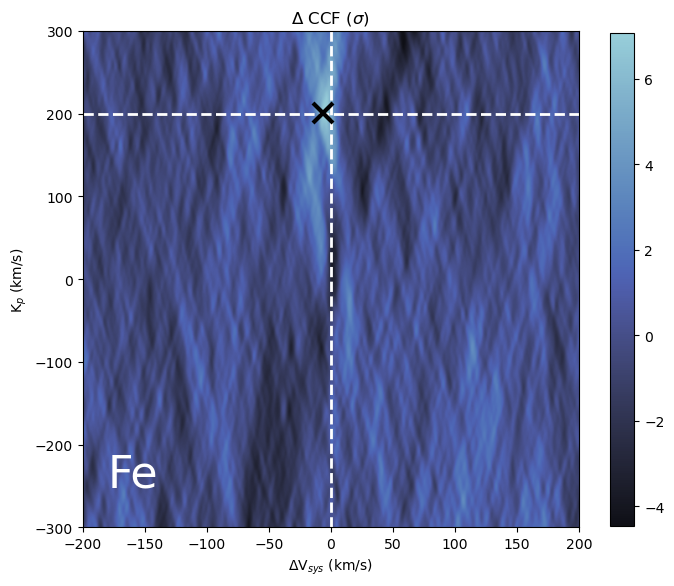

In [28]:
plot_CCF_Kp_Vsys(
    Kp_range,
    Vsys_range,
    np.sum(CCF_Kp_Vsys_all[:], axis=0),
    "Fe",
    200,
    Vsys=0,
    RM_mask_size=50,
    plot_label=True,
    savefig=False,
    plot_slice=False,
    file_path="./CC_output/WASP_121_CCF_Fe.pdf",
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)

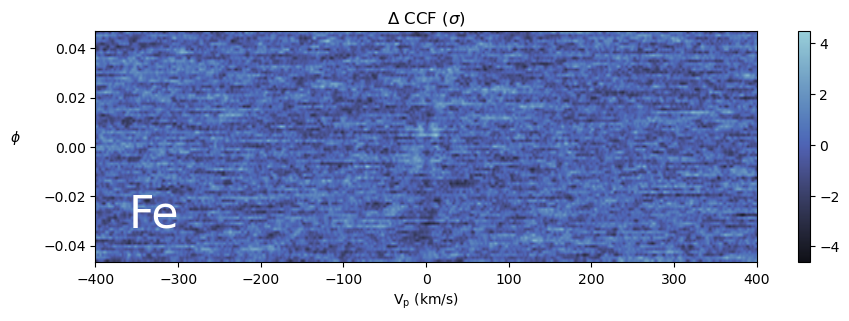

In [29]:
transit_model = data["blue"]["transit_weight"]
in_transit = transit_model != 1
phi = data["blue"]["phi"][in_transit]
plot_CCF_phase_RV(
    phi,
    RV_range,
    np.mean(CCF_phase_RV_all, axis=0)[in_transit],
    "Fe",
    plot_label=True,
    save_path=None,
    cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9),
)